# Description
This will focus on using classic regression models and bayesian models. 

#### NOTE: As described in EDA notebook, "Pseudo_ts" is concatenation of data from locally adjacent ski resorts (e.g., all resorts in Colorado) into a single timeseries.
# Imports

In [1]:
! pip install vapeplot arviz pystan stan_utility

     |████████████████████████████████| 1.5MB 5.4MB/s 
     |████████████████████████████████| 727kB 32.8MB/s 
     |████████████████████████████████| 4.3MB 41.6MB/s 
     |████████████████████████████████| 296kB 46.9MB/s 
  Created wheel for vapeplot: filename=vapeplot-0.0.8-cp36-none-any.whl size=11017 sha256=0897806eb8816843a975fc8d2f8304efe9492a7c1108b39f3360c99972139a98
  Stored in directory: /root/.cache/pip/wheels/5e/f5/95/d4cd5d6af4055b9adc70ff5860e557d58f0b3bdab1f7e0362a
Successfully built vapeplot
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1


In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import os
    from google.colab import drive
    drive.mount('/content/gdrive')
    base_path = r'/content/gdrive/My Drive/data_sci/colab/ski/'
    os.chdir(base_path)
    try:
        ! git clone https://github.com/chrisoyer/ski-snow-modeling/
    #normal try/except doesn't work on 'fatal' error
    except:
        ! git pull
    mod_path = os.path.join(base_path, 
                            r"ski-snow-modeling/src/analysis/project_utils/project_utils.py")
    import importlib.util
    spec = importlib.util.spec_from_file_location(name="utils.name", location=mod_path)
    utils = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(utils)
    
    os.chdir('./ski-snow-modeling/src/analysis/')
    # Change the working directory to the repo root.
    # Add the repo root to the Python path.
    import sys
    sys.path.append(os.getcwd())
else:
    # local running
    import project_utils as common

Mounted at /content/gdrive
fatal: destination path 'ski-snow-modeling' already exists and is not an empty directory.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [116]:
!git pull

remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 6 (delta 4), reused 6 (delta 4), pack-reused 0
Unpacking objects: 100% (6/6), done.
From https://github.com/chrisoyer/ski-snow-modeling
   ca2e0ac..0e2592f  master     -> origin/master
Updating ca2e0ac..0e2592f
Fast-forward
 src/analysis/project_utils/project_utils.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [117]:
# data wrangling
import numpy as np
import pandas as pd
import os.path
import pickle
import calendar
from typing import Union
from collections import namedtuple

# viz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import vapeplot
import arviz as az

# modeling
import pystan
import stan_utility
from sklearn.metrics import r2_score

# project specific
from project_utils import project_utils as common

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters

In [5]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')
plt.rc('figure', figsize=(11.0, 7.0))

# Load Data

In [6]:
file_path = r'../../data/snow_data_clean.parquet'
all_data_path = os.path.join(os.getcwd(), file_path)
model_path = r'./stan_model.pkl'
result_path = r'../../data/processed/stan_results.pkl'

In [7]:
# parquet opening is broken on colab
with open(file_path, 'rb') as parq_file:
    long_series_df = pd.read_parquet(parq_file)
assert long_series_df.base.isna().sum()==0

# Feature Engineering
refactored into project_utils module

### Split Data and sample dense areas

In [8]:
# I want to oversample rare months, but will want to use the last year as the test set.
long_series_df.query('basecol_interpolated==False')[['ski_yr', 'pseudo_ts', 'snowfall']]\
.assign(month=lambda x: x.pseudo_ts.dt.month)\
.drop(columns=['pseudo_ts'])\
.pivot_table(index=['month'], columns=['ski_yr'], values='snowfall', aggfunc='count')

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


ski_yr,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
month,,,,,,,,,
1,4735.0,6067.0,6227.0,6240.0,6331.0,5975.0,5989.0,5914.0,5840.0
2,4376.0,5545.0,5781.0,5716.0,5484.0,5650.0,5158.0,5277.0,4949.0
3,4491.0,4810.0,5852.0,5795.0,5017.0,4507.0,4608.0,5060.0,5043.0
4,1534.0,1596.0,1798.0,2009.0,1229.0,1318.0,1594.0,1646.0,1703.0
5,162.0,153.0,210.0,266.0,92.0,183.0,178.0,185.0,305.0
6,25.0,17.0,31.0,52.0,12.0,49.0,23.0,26.0,122.0
7,2.0,2.0,4.0,27.0,NaN,1.0,17.0,10.0,31.0
8,NaN,2.0,4.0,NaN,NaN,NaN,1.0,6.0,1.0
9,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0


In [9]:
# set aside some data for multi-step analysis
leaveouts = ['Eldora', 'Seven Springs']
stan_multistep_test_df = (long_series_df.query('station in @leaveouts')
                         .pipe(common.add_month)
                         .pipe(common.add_diff, ar_terms=1)
                         .pipe(common.ohe, 'region')
                         .pipe(common.monthly_mixture)
                         .pipe(common.cleaner))

add_month: time=0:00:00.002196, type=<class 'pandas.core.frame.DataFrame'>, shape=(7323, 13)
add_diff: time=0:00:00.016366, type=<class 'pandas.core.frame.DataFrame'>, shape=(7323, 14)
ohe: time=0:00:00.006390, type=<class 'pandas.core.frame.DataFrame'>, shape=(7323, 15)
monthly_mixture: time=0:00:00.027305, type=<class 'pandas.core.frame.DataFrame'>, shape=(7323, 27)
cleaner: time=0:00:00.006663, type=<class 'pandas.core.frame.DataFrame'>, shape=(2409, 19)


In [114]:
stan_train_df, stan_test_df = (long_series_df
           .drop(index=stan_multistep_test_df.index)
           .pipe(common.add_month)
           .pipe(common.add_diff, ar_terms=0)
           .pipe(common.ohe, 'region')
           .pipe(common.monthly_mixture)
           .pipe(common.cleaner)
           .pipe(common.train_test_split_ts, exog_cols='all', ski_yr_cutoff=7, as_monthly=False)
           )
stan_train_df = stan_train_df.pipe(common.sample_weighted_season)
train_data = common.subsets(stan_train_df)
test_data = common.subsets(stan_test_df)

stan_data_test = common.data_packager(train=train_data, test=test_data)

add_month: time=0:00:00.100662, type=<class 'pandas.core.frame.DataFrame'>, shape=(669813, 13)
add_diff: time=0:00:00.521400, type=<class 'pandas.core.frame.DataFrame'>, shape=(669813, 13)
ohe: time=0:00:00.113121, type=<class 'pandas.core.frame.DataFrame'>, shape=(669813, 20)
monthly_mixture: time=0:00:00.605059, type=<class 'pandas.core.frame.DataFrame'>, shape=(669813, 32)
cleaner: time=0:00:00.046582, type=<class 'pandas.core.frame.DataFrame'>, shape=(198030, 24)
sample_weighted_season: time=0:00:00.291686, type=<class 'pandas.core.frame.DataFrame'>, shape=(21816, 23)


# Bayesian Model in Stan (MCMC)
I want to add priors to the model that snowfall should only result in increases in base depth, and monthly effects should only result in reduction (i.e., monthly effect should measure strength of melting.); changes at odds with this should be considered as noise. A bayesian model allows for this.

In [13]:
functions_block = """// for function
"""
data_block_basic = """
    // input data passed from Python
    int<lower=1> N;               // number of data observations
    int<lower=1> K_month;         // no of melting predictor
    matrix[N, K_month] X_month;   // predictor for melting features
    int<lower=1> K_reg;           // no of region features
    matrix[N, K_reg] X_reg;       // region predictors
    matrix[N, 1] X_snow;          // snowfall predictor
    vector[N] y;                  // response vector
    """
data_block_test = """
    // test variables
    int<lower=1> N_test;                  // no of test records
    matrix[N_test, K_month] X_month_test; // predictor for melting features
    matrix[N_test, K_reg] X_reg_test;     // region predictors
    matrix[N_test, 1] X_snow_test;        // snowfall predictor testset
    """
data_block = data_block_basic + data_block_test

transformed_data_block = """
    matrix[N, K_reg] X_reg_snow;
    row_vector[N] X_snow_rvect = to_row_vector(X_snow);
    matrix[N_test, K_reg] X_reg_snow_test;
    row_vector[N_test] X_snow_rvect_test = to_row_vector(X_snow_test);
    
    for (k in 1:K_reg) {          //  K_regxN * Nx1  T
        for (n in 1:N) {
            X_reg_snow[n,k] = X_snow_rvect[n] * X_reg[n,k];
    }  }
    
    // same, but for test. Should do this with a function...
    for (k in 1:K_reg) {
        for (n in 1:N_test) {
            X_reg_snow_test[n,k] = X_snow_rvect_test[n] * X_reg_test[n,k];
    } }"""
parameters_block = """
    // intercept was causing divergences and coef interpretation 
    // makes more sense without intercept: 
    // I don't expect change in base depth absent melting or snowfall
    vector<upper=0>[K_month] beta_mo;           // coefficients for melting
    vector<lower=0, upper=1>[K_reg] beta_reg_snow;       // coef for region x snow interaction
    real<lower=0> sigma;                        // must be +ve
    real<lower=0> sig_mos;                      // must be +ve
    """
transformed_parameters_block = """ """
model_block_vars = """
    vector[N] mu;                       // y_hat
    """
model_block_sampling = """
    sigma ~ cauchy(0, 10);              // half Cauchy
    sig_mos ~ cauchy(0, 20);
    for (n in 1:K_month) {
        beta_mo[n] ~ normal(0, sig_mos) T[,0]; // sample from normal, only -ve
    }
    // prior on snow columns is beta over [0,1]
    beta_reg_snow ~ beta(2.2, 3);         // reparameterize so this and snow are from beta dist"""
model_block_y = """
    mu = X_month*beta_mo + X_reg_snow*beta_reg_snow;
    y ~ normal(mu, sigma);
    """
model_block = model_block_vars + model_block_sampling + model_block_y
generated_quantities_block = """
    vector[N_test] y_test;
    for(n in 1:N_test) {
        y_test[n] = normal_rng(X_month_test[n]*beta_mo + X_reg_snow_test[n]*beta_reg_snow, sigma);
    }
    """
# assemble model
def create_stan_model(functions_block=functions_block, data_block=data_block, 
                      transformed_data_block=transformed_data_block, 
                      parameters_block=parameters_block, 
                      transformed_parameters_block=transformed_parameters_block, model_block=model_block,
                      generated_quantities_block=generated_quantities_block):
    return f'''
    functions {{{functions_block}}}
    data {{{data_block}}}
    transformed data {{{transformed_data_block}}}
    parameters {{{parameters_block}}}
    transformed parameters {{{transformed_parameters_block}}}
    model {{{model_block}}}
    generated quantities {{{generated_quantities_block}}}'''

stan_model_str = create_stan_model(generated_quantities_block=" ")

In [14]:
sm = pystan.StanModel(model_code=stan_model_str, model_name='stan_model')
print(stan_model_str)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL stan_model_e41f59a6f9a3d55a4f7a35c7ba50e2b5 NOW.



    functions {// for function
}
    data {
    // input data passed from Python
    int<lower=1> N;               // number of data observations
    int<lower=1> K_month;         // no of melting predictor
    matrix[N, K_month] X_month;   // predictor for melting features
    int<lower=1> K_reg;           // no of region features
    matrix[N, K_reg] X_reg;       // region predictors
    matrix[N, 1] X_snow;          // snowfall predictor
    vector[N] y;                  // response vector
    
    // test variables
    int<lower=1> N_test;                  // no of test records
    matrix[N_test, K_month] X_month_test; // predictor for melting features
    matrix[N_test, K_reg] X_reg_test;     // region predictors
    matrix[N_test, 1] X_snow_test;        // snowfall predictor testset
    }
    transformed data {
    matrix[N, K_reg] X_reg_snow;
    row_vector[N] X_snow_rvect = to_row_vector(X_snow);
    matrix[N_test, K_reg] X_reg_snow_test;
    row_vector[N_test] X_snow_rvect_te

In [15]:
# avoid recompile if possible
with open(model_path, 'wb') as f:
    pickle.dump(sm, f)

In [16]:
fit = sm.sampling(data=stan_data_test, iter=2_000, chains=4, n_jobs=-1,
                  sample_file="../../data/processed/stan_samples",
                  control={'adapt_delta': 0.85, # p accepting posterior draw
                           'stepsize': 1,  # just starting stepsize
                          }, 
                  seed=42, verbose=True)

In [17]:
# for overnight run
try:
    with open(result_path, 'wb') as f:
        pickle.dump(fit, f)
# reload saved objects if not reruning sampler
except NameError:
    with open(model_path, 'rb') as f:
        sm = pickle.load(f)
    with open(result_path, 'rb') as f:
        fit = pickle.load(f)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  after removing the cwd from sys.path.


## MCMC Diagnostics
We will want to check:
1. Model actually runs.
1. Good Mixing of Chains: (fix with stronger prior, reparameterization)
    1. $\hat{R}$ is 1.1 or under for all parameters.
    1. When n_eff / n_transitions < 0.001 the estimators that we use are often biased and can significantly overestimate the true effective sample size.
1. Check tree depth:
if threshold saturated, increase tree depth _control={max_treedepth: 15}_
1. No Divergences! fix by reparameterization to avoid 'funnel' spots, or increasing adapt_delta, which causes smaller step size by requiring higher probability of step acceptance.

_



In [18]:
stan_utility.check_all_diagnostics(fit)

n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


## Visualization of results

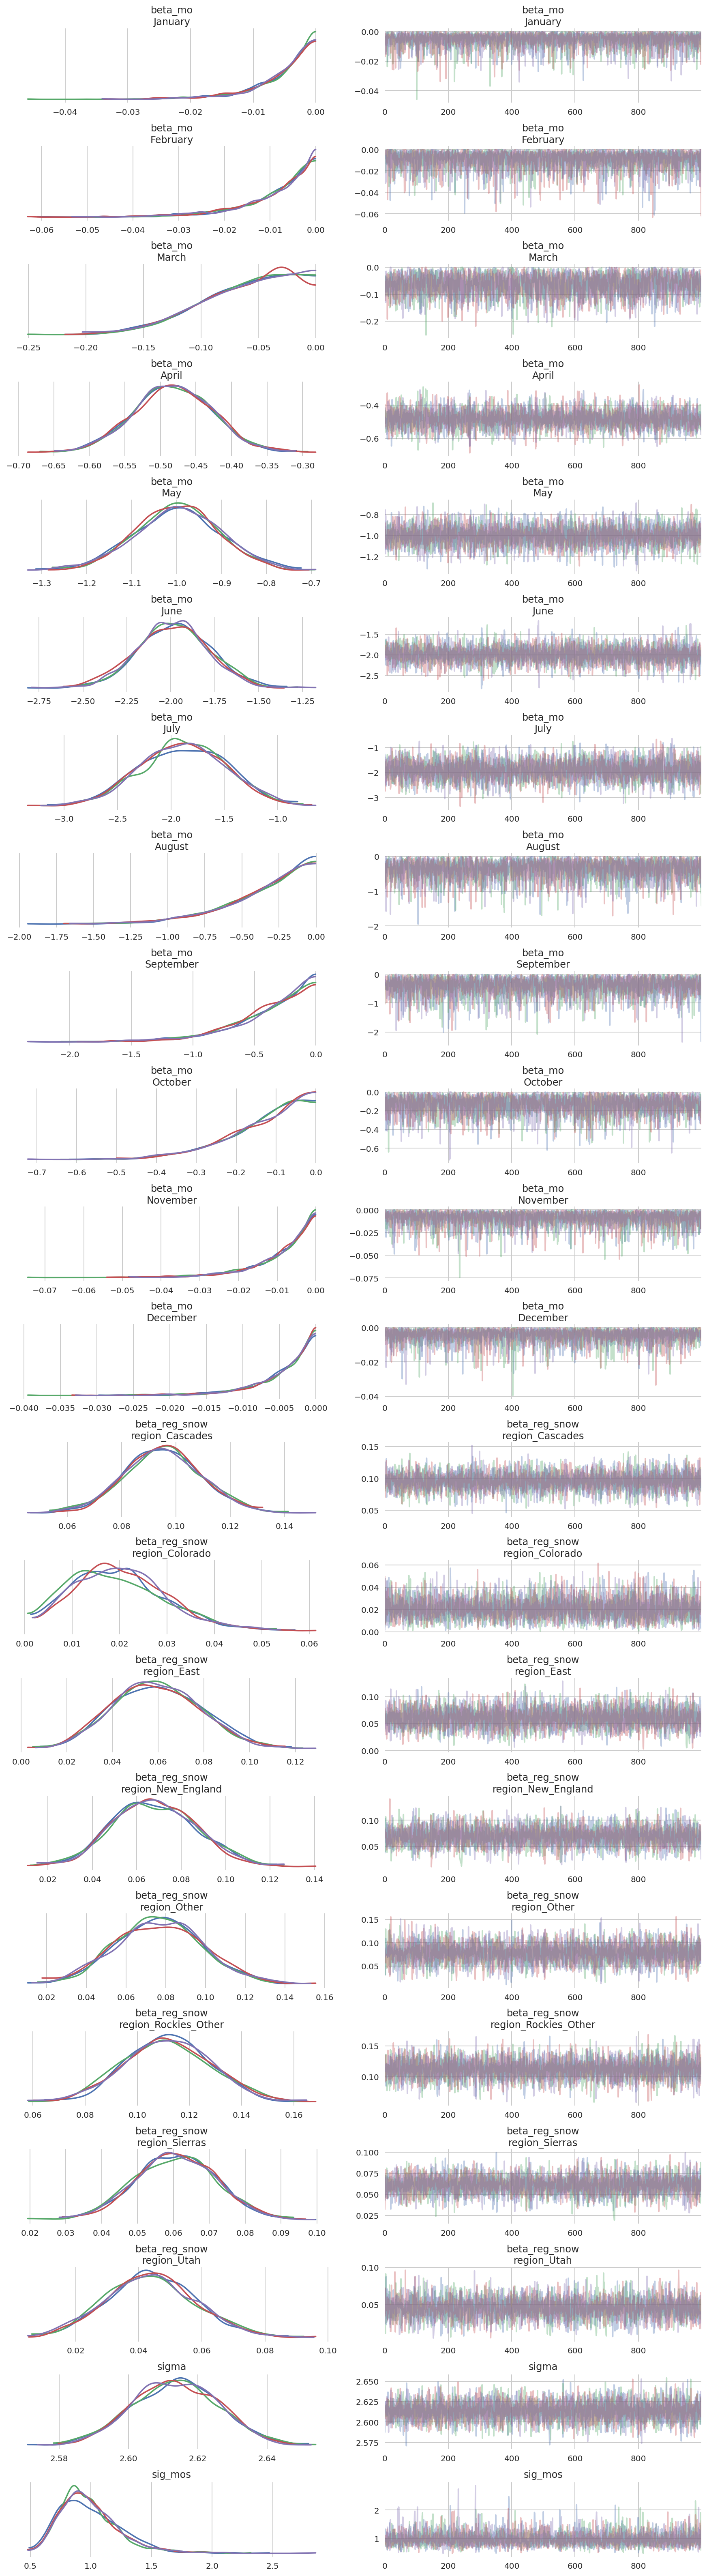

In [24]:
fit_az = az.from_pystan(posterior=fit,
                        dims={'beta_reg_snow': ['Coefficients_for_Snow_by_Region'],
                              'beta_mo': ['Melting_Coefficients_by_Month']},
                        coords={'Coefficients_for_Snow_by_Region': train_data.X_region.columns.values.tolist(),
                                'Melting_Coefficients_by_Month': [calendar.month_name[i+1] for i in range(12)]}
                        )
rc = {'plot.max_subplots': None}
az.rcParams.update(rc)
sns.set_style('whitegrid')
az.plot_trace(fit_az);

In [25]:
# fix brackets in col nmaes
fit_df = (fit.to_dataframe()
          .rename(columns=lambda x: x.replace("[", "_"))
          .rename(columns=lambda x: x.replace("]", "")))

fit_df.head()

,chain,draw,warmup,beta_mo_1,beta_mo_2,beta_mo_3,beta_mo_4,beta_mo_5,beta_mo_6,beta_mo_7,beta_mo_8,beta_mo_9,beta_mo_10,beta_mo_11,beta_mo_12,beta_reg_snow_1,beta_reg_snow_2,beta_reg_snow_3,beta_reg_snow_4,beta_reg_snow_5,beta_reg_snow_6,beta_reg_snow_7,beta_reg_snow_8,sigma,sig_mos,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,-0.008672,-0.005779,-0.088107,-0.496035,-0.860393,-1.944264,-1.268205,-0.875237,-0.248838,-0.088388,-0.004101,-0.000846,0.106632,0.004233,0.035769,0.037285,0.060572,0.136186,0.048242,0.044013,2.587473,0.732340,-31948.738530,0.891658,0.294611,3,7,0,31953.462908
1,0,1,0,-0.004750,-0.006167,-0.089857,-0.418028,-1.121441,-1.921712,-2.489892,-0.782648,-0.302145,-0.004815,-0.011469,-0.001441,0.084533,0.047879,0.066868,0.039255,0.030914,0.096469,0.043281,0.037815,2.613673,1.334612,-31949.279811,0.984951,0.294611,4,15,0,31962.998524
2,0,2,0,-0.005077,-0.006224,-0.077420,-0.507910,-0.914078,-2.239948,-1.835240,-0.615806,-0.201878,-0.121361,-0.012296,-0.001554,0.125173,0.007977,0.050415,0.103296,0.053528,0.113659,0.062811,0.052369,2.606292,0.728774,-31942.036777,1.000000,0.294611,4,15,0,31957.846526
3,0,3,0,-0.004774,-0.008675,-0.035369,-0.509036,-1.116647,-1.732228,-2.181412,-0.151602,-0.524447,-0.084711,-0.006068,-0.001743,0.086747,0.036175,0.054856,0.056676,0.109190,0.090997,0.072779,0.051668,2.623701,1.261976,-31940.813583,0.948923,0.294611,4,15,0,31951.239625
4,0,4,0,-0.003092,-0.006099,-0.092152,-0.455551,-1.133248,-1.620576,-2.535468,-0.475697,-0.209981,-0.412691,-0.029925,-0.004898,0.092916,0.018215,0.068283,0.068968,0.088238,0.084624,0.065285,0.087446,2.617492,0.956748,-31944.264490,0.922640,0.294611,3,7,0,31952.043715


In [27]:
# get region names without "region_"
region_names = [reg[7:] for reg in train_data.X_region.columns.values.tolist()]

region_betas_df = fit_df.filter(regex="reg", axis=1)
reg_cols = region_betas_df.columns
region_betas_df = (region_betas_df
                   .rename(columns={col: reg_name for col, reg_name 
                                    in zip(reg_cols, region_names)})
                   .melt(var_name="region"))
region_betas_df.head(2)

,region,value
0,Cascades,0.106632
1,Cascades,0.084533


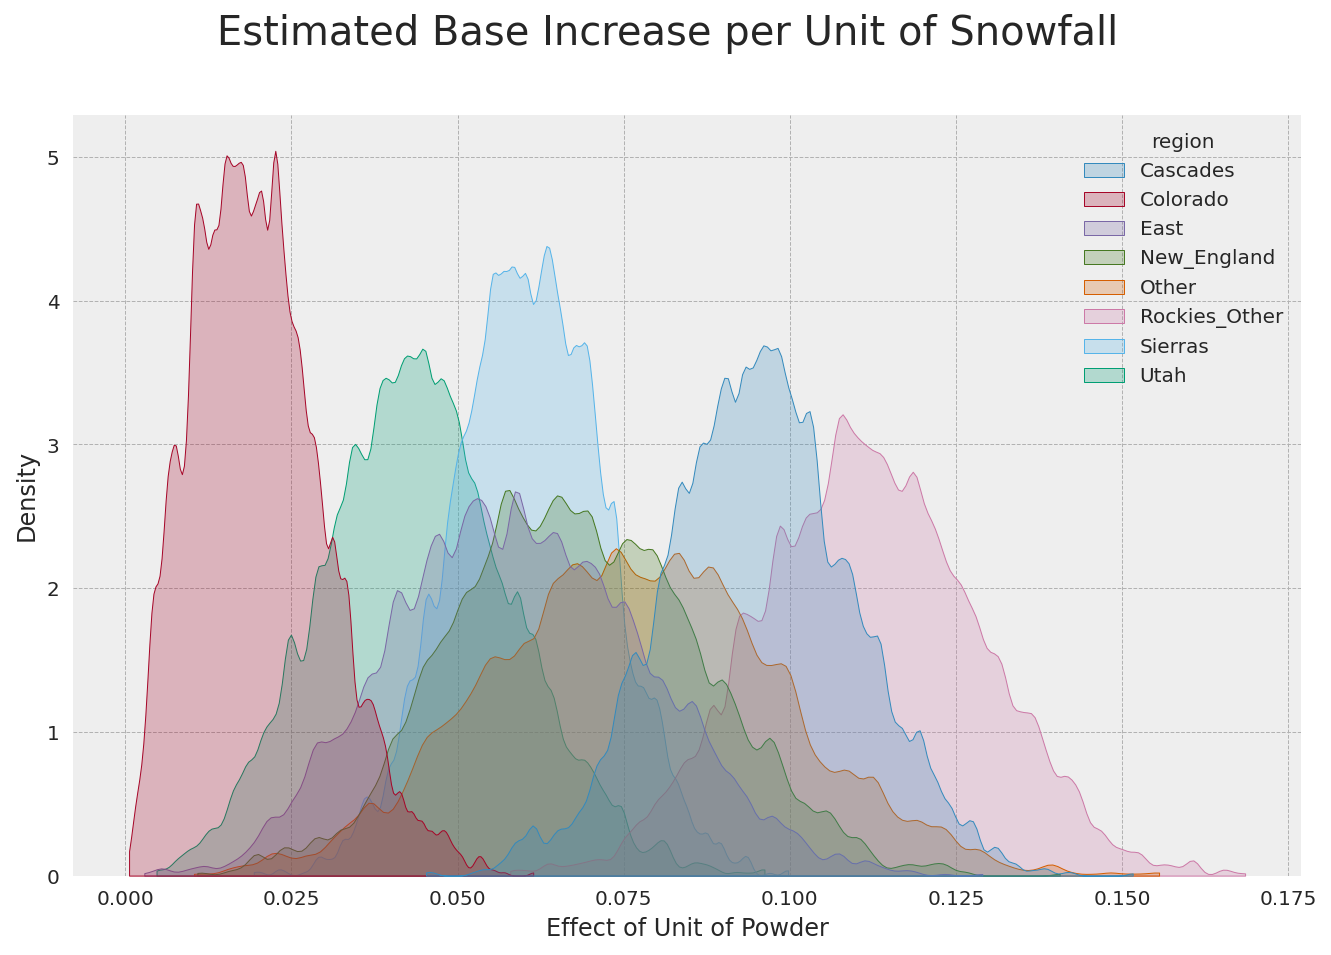

In [28]:
plt.style.use('bmh')
fig = sns.kdeplot(x=region_betas_df.value, hue=region_betas_df.region, fill=True, cut=0, bw_adjust=.3)
plt.suptitle("Estimated Base Increase per Unit of Snowfall", fontsize=20)
plt.xlabel("Effect of Unit of Powder");

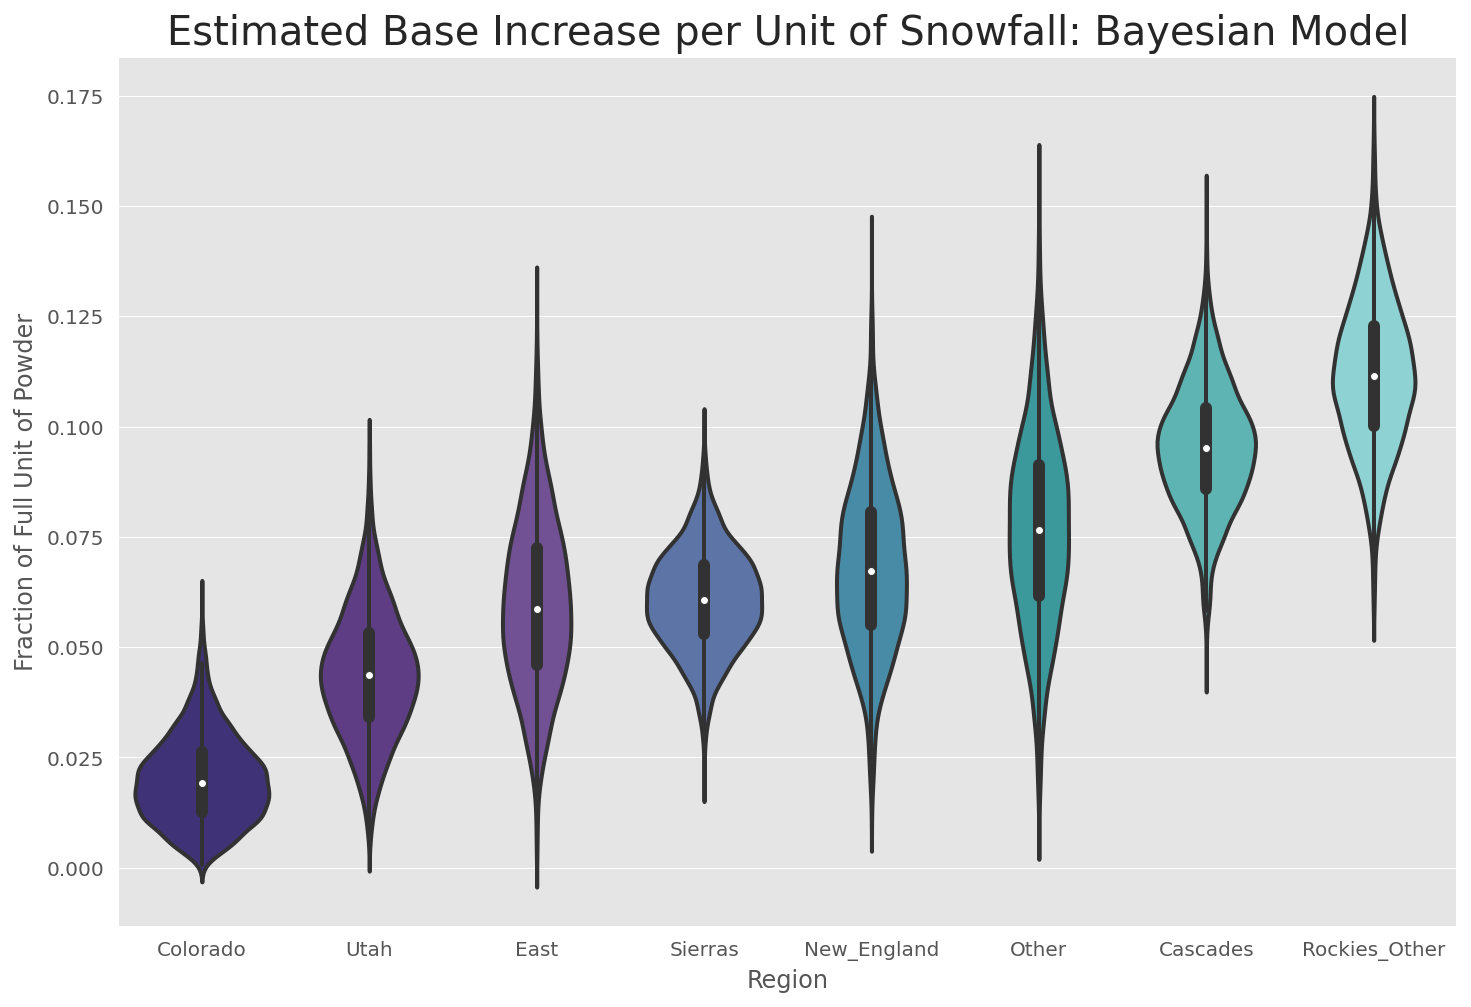

In [29]:
plt.style.use('ggplot')
jazzcup = sns.blend_palette(vapeplot.palette("jazzcup"), n_colors=region_betas_df.region.unique().size)
f, ax = plt.subplots(figsize=(12, 8))
sort_order = region_betas_df.groupby(['region']).mean().sort_values(by='value', ascending=True).index

sns.violinplot(x='region', y='value', data=region_betas_df,
            order=sort_order, palette=jazzcup)

plt.title("Estimated Base Increase per Unit of Snowfall: Bayesian Model", fontsize=20)
plt.xlabel('Region')
plt.ylabel('Fraction of Full Unit of Powder');

In [30]:
month_betas_df = fit_df.filter(like='beta_mo').melt(var_name="month")
month_betas_df = month_betas_df[month_betas_df.value > month_betas_df.value.quantile(.02)]
month_map = {f"beta_mo_{i}": calendar.month_abbr[i] for i in range(1, 13)}
#month_betas_df['month'] = pd.to_datetime(month_betas_df['month'].replace(month_map), format="%B").dt.month.astype('category')
month_betas_df['month'] = month_betas_df['month'].replace(month_map).astype('str')
month_betas_df.head()

,month,value
0,Jan,-0.008672
1,Jan,-0.004750
2,Jan,-0.005077
3,Jan,-0.004774
4,Jan,-0.003092


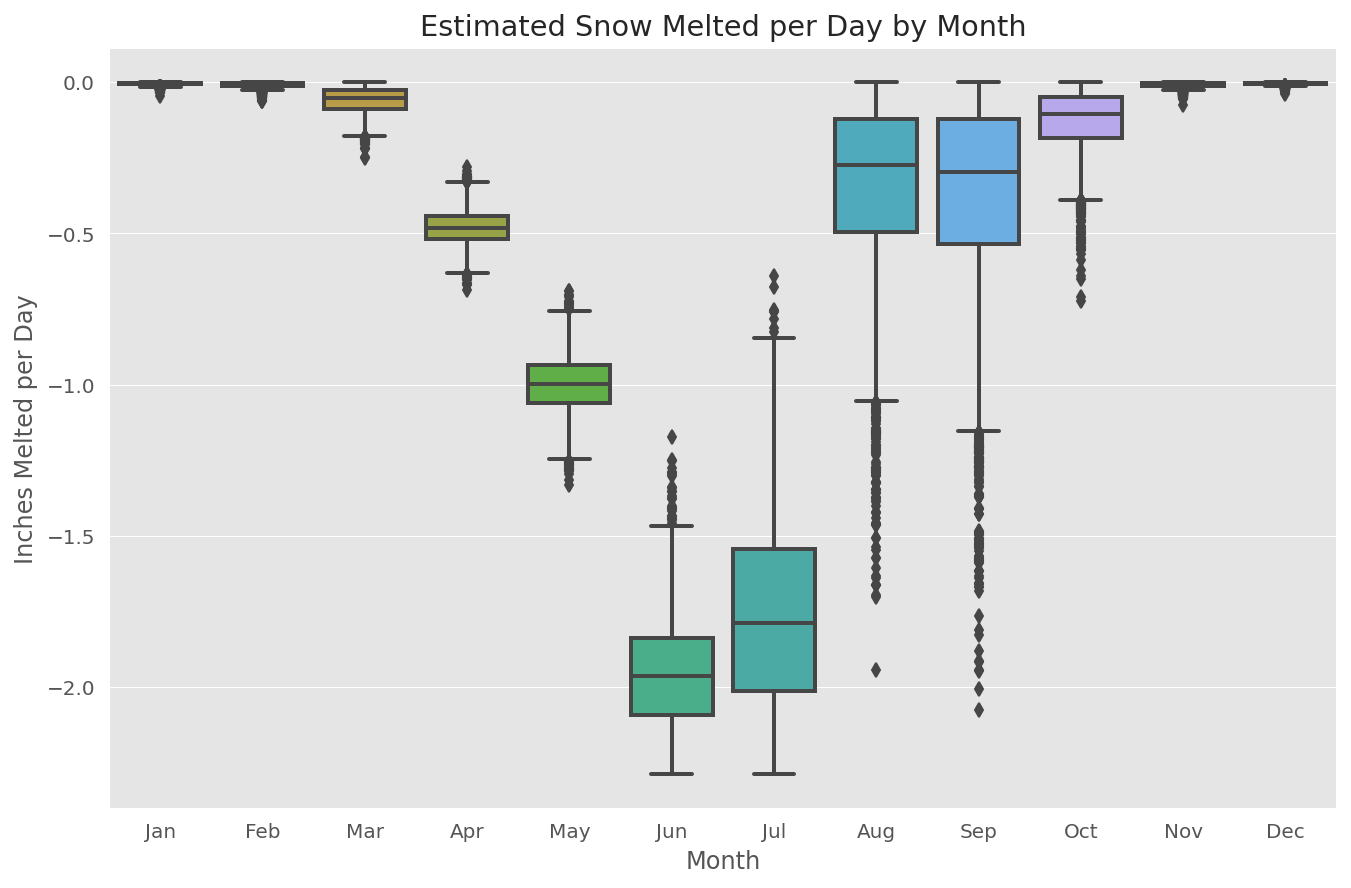

In [31]:
def plot_snow_betas(df, start_mo):
    fig, ax = plt.subplots()
    month_ordered = [mo for mo in calendar.month_abbr[1:] if mo in df.month.unique()]
    start_mo_ix = month_ordered.index(start_mo)
    month_ordered = month_ordered[start_mo_ix:] + month_ordered[:start_mo_ix]
    sns.boxplot(data=df, y='value', x='month', order=month_ordered,
                ax=ax, )
    ax.set_ylabel('Inches Melted per Day')
    ax.set_xlabel('Month')
    ax.set_title('Estimated Snow Melted per Day by Month');
plot_snow_betas(month_betas_df, "Jan")

These estimates are mostly expected, but there seems to be low melting amounts during summer...this can be explained when we realize that most of the values for July-Sept are from the handful of resorts with glacier skiing. The averages aren't weighted by ski acreage, so the large number of small ski stations on the east coast & midwest with short seasons are disproportionately affecting these numbers. We could extend the model by breakin out melting to just the interaction of month x region.

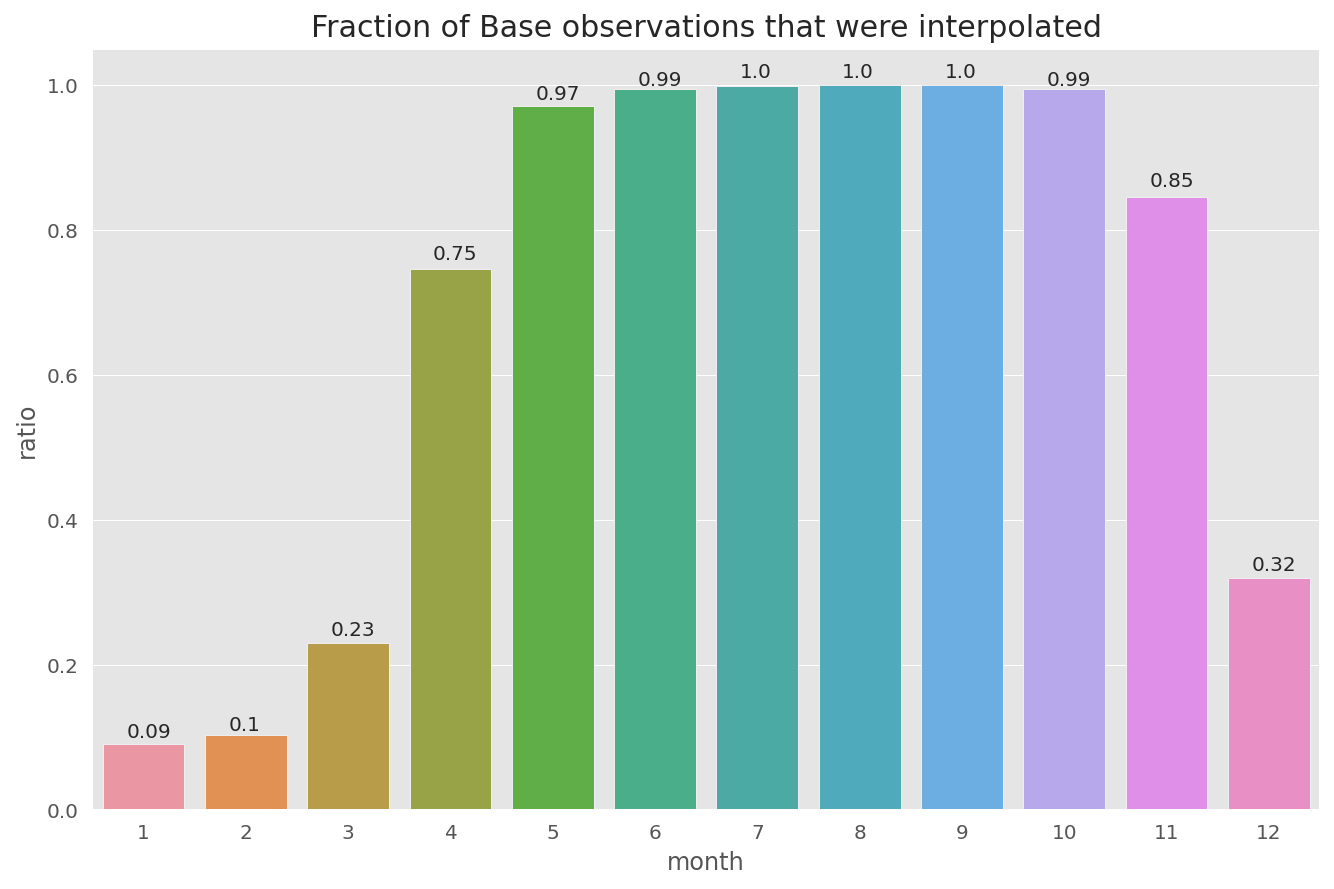

In [32]:
interpo_ratios=(long_series_df
    .assign(month=lambda x: x.pseudo_ts.dt.month)
    .groupby('month')
    .apply(lambda x: x.basecol_interpolated.sum()/x.shape[0])
    .to_frame()
    .reset_index()
    .rename(columns={0:'ratio'})
)
fig, ax = plt.subplots()
sns.barplot(data=interpo_ratios, x='month', y='ratio', ax=ax)
plt.title('Fraction of Base observations that were interpolated', fontsize=15)
[plt.text((i-.17), value+.01, str(value)) for i, value in enumerate(interpo_ratios.ratio.round(2).to_numpy())];

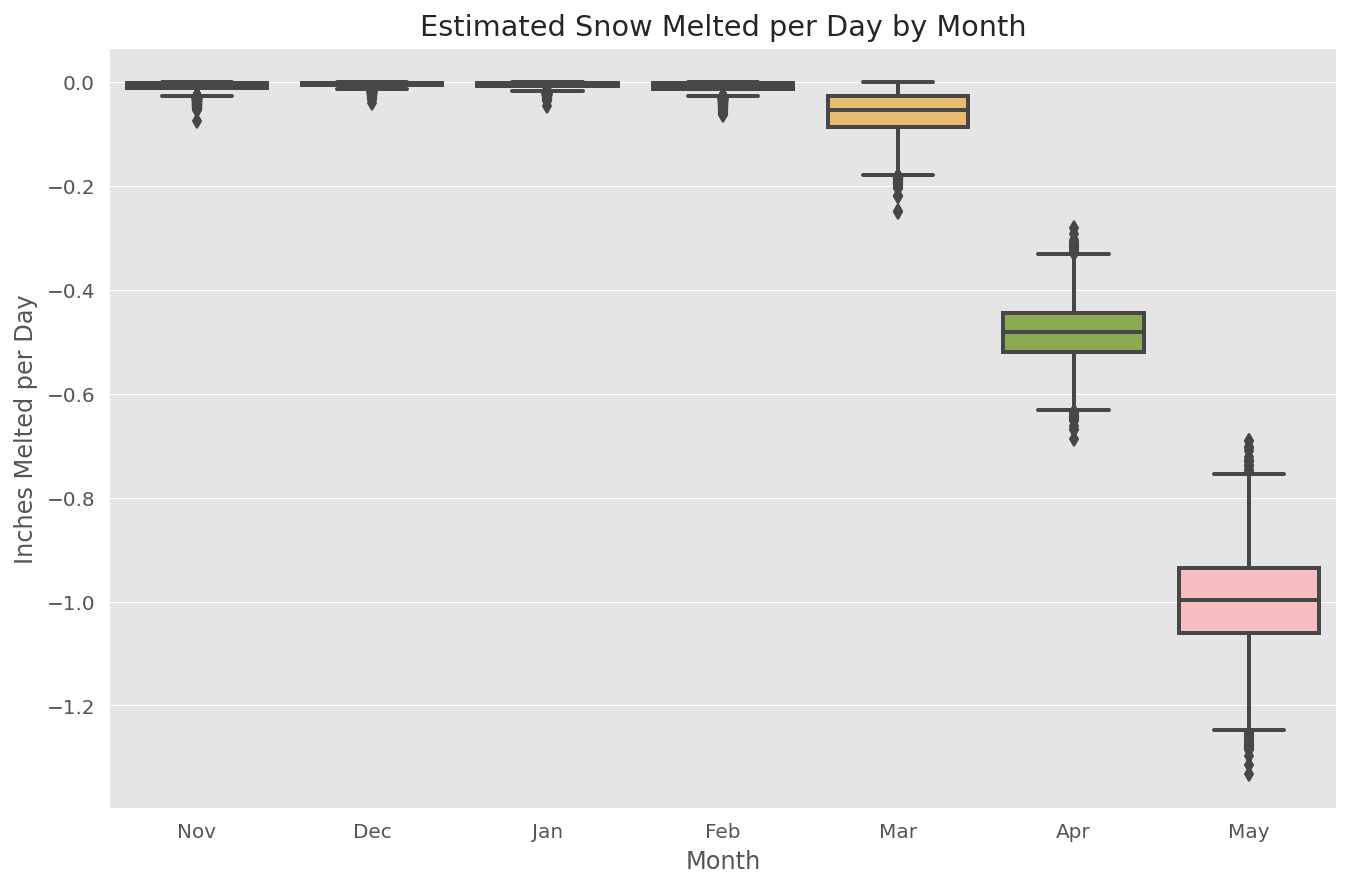

In [33]:
plot_snow_betas(month_betas_df[~month_betas_df.month.isin(['Jun', 'Jul', 'Aug', 'Sep', 'Oct'])], "Nov")

### Check test set metrics

In [34]:
stan_model_wtest_str = create_stan_model()
sm_wtest = pystan.StanModel(model_code=stan_model_wtest_str, model_name='stan_model_wtest')
fit_wtest = sm_wtest.sampling(data=stan_data_test, iter=2_000, chains=4, n_jobs=-1,
                  sample_file="../../data/processed/stan_samples",
                  control={'adapt_delta': 0.85, # p accepting posterior draw
                           'stepsize': 1,  # just starting stepsize
                          }, 
                  seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL stan_model_wtest_421e1b44f9056e92ce39d134b1866e9b NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [35]:
def model_score(fit_object=fit_wtest, input_data=stan_test_df) -> None:
    y_pred = pd.DataFrame(data=fit_object.extract(['y_test'], inc_warmup=False)['y_test'].T.mean(axis=1),
                      columns=['y_pred'])
    y_true = stan_test_df[['pseudo_ts', 'delta_base']]
    y_true.index = pd.to_datetime(y_true.index)
    print(f"R2 score for model: {r2_score(y_true=y_true.delta_base, y_pred=y_pred)}")
    y_pred_w_old = (pd.concat([y_pred.reset_index(drop=True),
                              y_true.reset_index(drop=True)],
                              axis=1, ignore_index=True)
                    .rename(columns={0:'y_pred', 1: 'pseudo_ts', 2: 'y_true'})
                    .set_index('pseudo_ts'))
    y_monthly = y_pred_w_old.resample('M').mean().dropna()    
    print(f"R2 score aggregated by month: {r2_score(y_true=y_monthly.y_true, y_pred=y_monthly.y_pred)}") 
model_score()

R2 score for model: 0.004996799653242845
R2 score aggregated by month: 0.3009369792330001


# Stan model including ARMA terms
I will not be using a seasonal model, since I think using months as predictors is more useful to capture seasonal changes in an interpretable way. However, I do want to caputure ARMA terms to improve model performance.

Because I am also calculating change in the base, this is a version of a (1,1,0) ARIMA model.

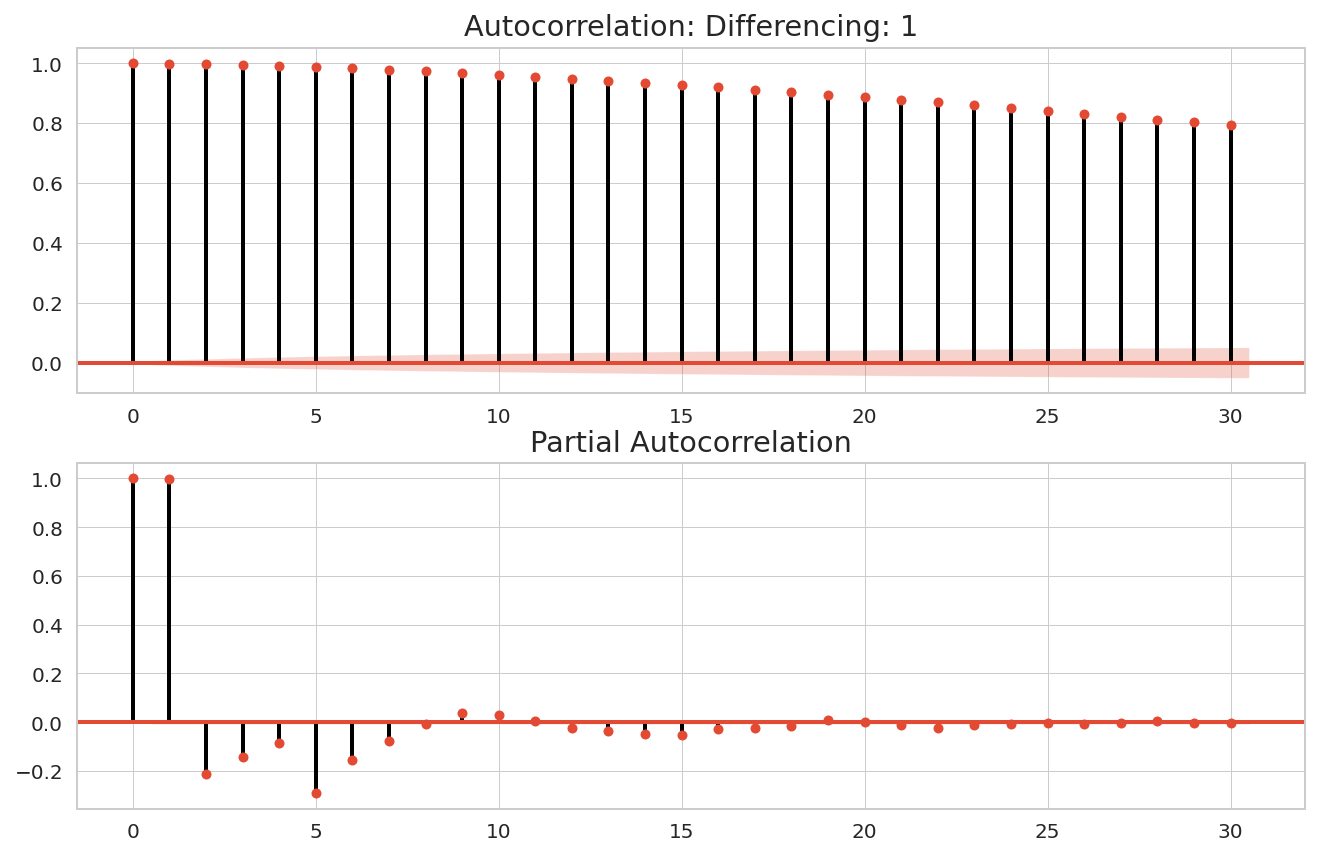

In [48]:
plt.rc('figure', figsize=(11.0, 7.0))
sns.set_style('whitegrid')
common.AC_PAC_plotter(df=long_series_df.query('ski_yr==1')[['base']], differences=1)

There is a long decay in the ACF, and a single (not including the 0 lag) positive PACF correlation. This is a classic AR(1) signature, so I will add that to the model. Adding another differencing term might be even better, but then all of the coefficients would lose the usefulness of their interpretability.

One way to at an AR relationship to the model would be with a line in the model:

`y[2:N] ~ normal(mu + y[1:(N - 1)]*beta_ar, sigma);`

but another is to add the lagged term as a feature and regress on it directly. (this wouldn't work for a MA term). This is useful because I can still sample from the data which helps with the dataset size.

In [118]:
# prepare data with AR feature
stan_train_ar_df, stan_test_ar_df = (long_series_df
           .drop(index=stan_multistep_test_df.index)
           .pipe(common.add_month)
           .pipe(common.add_diff, ar_terms=1)
           .pipe(common.ohe, 'region')
           .pipe(common.monthly_mixture)
           .pipe(common.cleaner)
           .pipe(common.train_test_split_ts, exog_cols='all', ski_yr_cutoff=7, as_monthly=False)
           )
stan_train_a_df = stan_train_ar_df.pipe(common.sample_weighted_season)
train_ar_data = common.subsets(stan_train_ar_df)
test_ar_data = common.subsets(stan_test_ar_df)

stan_data_ar_test = common.data_packager(train=train_ar_data, test=test_ar_data)

add_month: time=0:00:00.104658, type=<class 'pandas.core.frame.DataFrame'>, shape=(669813, 13)
add_diff: time=0:00:00.498424, type=<class 'pandas.core.frame.DataFrame'>, shape=(669813, 14)
ohe: time=0:00:00.139865, type=<class 'pandas.core.frame.DataFrame'>, shape=(669813, 21)
monthly_mixture: time=0:00:00.609114, type=<class 'pandas.core.frame.DataFrame'>, shape=(669813, 33)
cleaner: time=0:00:00.047967, type=<class 'pandas.core.frame.DataFrame'>, shape=(198030, 25)
sample_weighted_season: time=0:00:00.282771, type=<class 'pandas.core.frame.DataFrame'>, shape=(21816, 24)


In [68]:
print(model_block_vars + model_block_sampling + model_block_y)


    vector[N] mu;                       // y_hat
    
    sigma ~ cauchy(0, 10);              // half Cauchy
    sig_mos ~ cauchy(0, 20);
    for (n in 1:K_month) {
        beta_mo[n] ~ normal(0, sig_mos) T[,0]; // sample from normal, only -ve
    }
    // prior on snow columns is beta over [0,1]
    beta_reg_snow ~ beta(2.2, 3);         // reparameterize so this and snow are from beta dist
    mu = X_month*beta_mo + X_reg_snow*beta_reg_snow;
    y ~ normal(mu, sigma);
    


In [107]:
data_block_ar = data_block_basic + """
    matrix[N, 1] X_ar;   // autoregressive predictor features""" + data_block_test + """
    matrix[N_test, 1] X_ar_test;"""

parameters_block_ar = parameters_block + """
    real beta_ar;           // coefficients for prior days change in base
    """

model_block_ar = """
    vector [N] mu;
    sigma ~ cauchy(1, 10);
    sig_mos ~ cauchy(0, 20);
    for (n in 1:K_month) {
        beta_mo[n] ~ normal(0, sig_mos) T[,0];
    }
    beta_reg_snow ~ beta(2.2, 3);
    beta_ar ~ normal(0, 5);
    for (n in 1:N) {
        mu[n] = X_month[n]*beta_mo + X_reg_snow[n]*beta_reg_snow + sum(X_ar[n]*beta_ar);
    }
    y ~ normal(mu, sigma);
    """

generated_quantities_ar = """
    vector[N_test] y_test;
    for(n in 1:N_test) {
        y_test[n] = normal_rng(X_month_test[n]*beta_mo + X_reg_snow_test[n]*beta_reg_snow + sum(X_ar_test[n]*beta_ar), sigma);
    }
"""

In [108]:
stan_model_ar_str = create_stan_model(data_block=data_block_ar, parameters_block=parameters_block_ar,
                                      model_block=model_block_ar, generated_quantities_block=generated_quantities_ar)
print(stan_model_ar_str)


    functions {// for function
}
    data {
    // input data passed from Python
    int<lower=1> N;               // number of data observations
    int<lower=1> K_month;         // no of melting predictor
    matrix[N, K_month] X_month;   // predictor for melting features
    int<lower=1> K_reg;           // no of region features
    matrix[N, K_reg] X_reg;       // region predictors
    matrix[N, 1] X_snow;          // snowfall predictor
    vector[N] y;                  // response vector
    
    matrix[N, 1] X_ar;   // autoregressive predictor features
    // test variables
    int<lower=1> N_test;                  // no of test records
    matrix[N_test, K_month] X_month_test; // predictor for melting features
    matrix[N_test, K_reg] X_reg_test;     // region predictors
    matrix[N_test, 1] X_snow_test;        // snowfall predictor testset
    
    matrix[N_test, 1] X_ar_test;}
    transformed data {
    matrix[N, K_reg] X_reg_snow;
    row_vector[N] X_snow_rvect = to_row_ve

In [109]:
sm_ar = pystan.StanModel(model_code=stan_model_ar_str, model_name='stan_model_ar')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL stan_model_ar_d64a81b44597706f6c53c3349c14fd05 NOW.


In [126]:
stan_data_test['X_month']

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0.9, 0.1, ..., 0. , 0. , 0. ],
       [0.6, 0. , 0. , ..., 0. , 0. , 0.4],
       [0.8, 0.2, 0. , ..., 0. , 0. , 0. ]])

In [125]:
stan_data_ar_test['X_month']

array([[0.0, 0.0, 0.0, ..., 0.9666666666666667, 0.033333333333333326,
        'month_11'],
       [0.0, 0.0, 0.0, ..., 0.9333333333333333, 0.06666666666666665,
        'month_11'],
       [0.0, 0.0, 0.0, ..., 0.9, 0.09999999999999998, 'month_11'],
       ...,
       [0.0, 0.0, 0.4666666666666667, ..., 0.0, 0.0, 'month_4'],
       [0.0, 0.0, 0.43333333333333335, ..., 0.0, 0.0, 'month_4'],
       [0.0, 0.0, 0.4, ..., 0.0, 0.0, 'month_4']], dtype=object)

In [119]:
fit_ar = sm_ar.sampling(data=stan_data_ar_test, iter=200, chains=4, n_jobs=-1,
                  sample_file="../../data/processed/stan_samples_ar",
                  control={'adapt_delta': 0.85, # p accepting posterior draw
                           'stepsize': 1,  # just starting stepsize
                          }, 
                  seed=42, verbose=True)

ValueError: ignored

In [ ]:
stan_utility.check_all_diagnostics(fit_ar)

In [ ]:
fit_ar.extract(['y_test'])

In [ ]:
model_score(fit_object=fit_ar)